In [1]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pydot
import glob 
import matplotlib.pyplot as plotter

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')


In [2]:
image_data = '/FGD/Acadamics and University/Python/Intelligent Systems/Project/rescal224 - split 2/train'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,Angry
1,Happy
2,Neutral
3,Sad
4,Surprise


In [3]:
files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,/FGD/Acadamics and University/Python/Intellige...,train\Sad
1,/FGD/Acadamics and University/Python/Intellige...,train\Neutral
2,/FGD/Acadamics and University/Python/Intellige...,train\Happy
3,/FGD/Acadamics and University/Python/Intellige...,train\Angry
4,/FGD/Acadamics and University/Python/Intellige...,train\Happy
...,...,...
11392,/FGD/Acadamics and University/Python/Intellige...,train\Happy
11393,/FGD/Acadamics and University/Python/Intellige...,train\Neutral
11394,/FGD/Acadamics and University/Python/Intellige...,train\Sad
11395,/FGD/Acadamics and University/Python/Intellige...,train\Neutral


Label
train\Neutral     28.26
train\Sad         27.61
train\Happy       26.25
train\Angry        9.21
train\Surprise     8.66
Name: proportion, dtype: float64


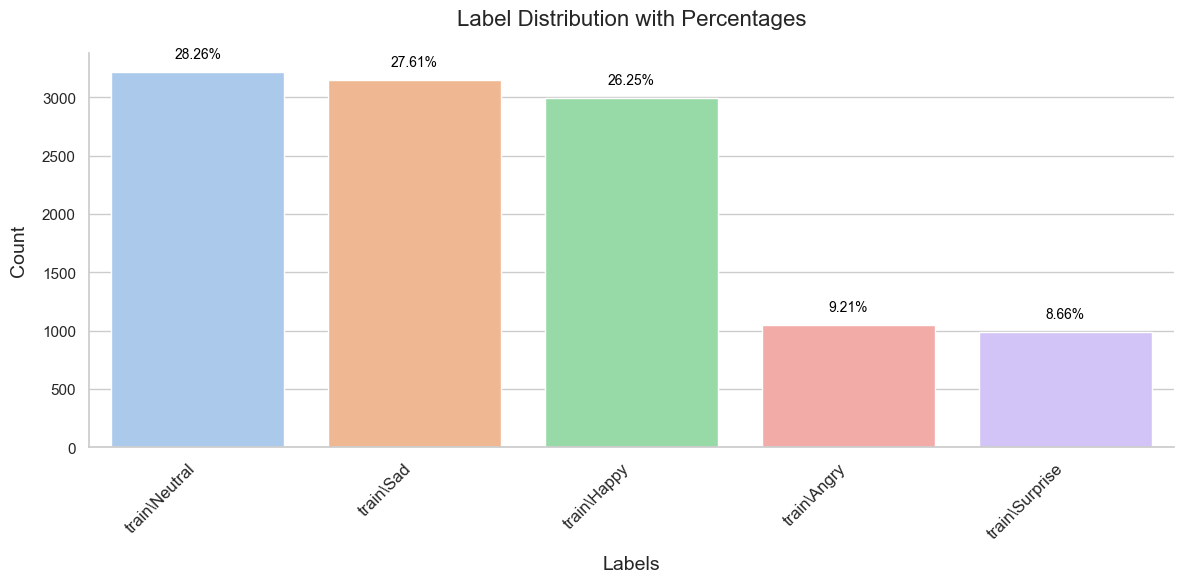

In [4]:
# Calculate counts and percentages for each label
sns.set_theme(style="whitegrid")
count_data = dataframe["Label"].value_counts()
percentage_data = round(dataframe["Label"].value_counts(normalize=True) * 100,2)  # Calculate percentage
print(percentage_data)

# Plot the count plot with sorted labels
sorted_data = count_data.sort_values(ascending=False).index
palette = sns.color_palette("pastel", len(sorted_data))
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=dataframe["Label"], order=sorted_data, palette=palette)

for p in ax.patches:
    height = p.get_height()  # Get the height of the bar
    percentage = f'{(height / count_data.sum()) * 100:.2f}%'  # Calculate percentage
    ax.annotate(percentage,  # The label to be annotated
                (p.get_x() + p.get_width() / 2., height),  # Position of the label
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 8), textcoords='offset points')

# Rotate x-axis labels for better visibility and set the label font size
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add title and labels with improved fonts and padding
plt.title("Label Distribution with Percentages", fontsize=16, pad=20)
plt.xlabel("Labels", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [5]:
train_data_dir = image_data
batch_size = 64
target_size = (224,224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

for images, labels in train.take(1):
    print(images.shape)  
    print(labels.shape)  

Found 11397 files belonging to 5 classes.
Using 9118 files for training.
Found 11397 files belonging to 5 classes.
Using 2279 files for validation.
(64, 224, 224, 3)
(64,)


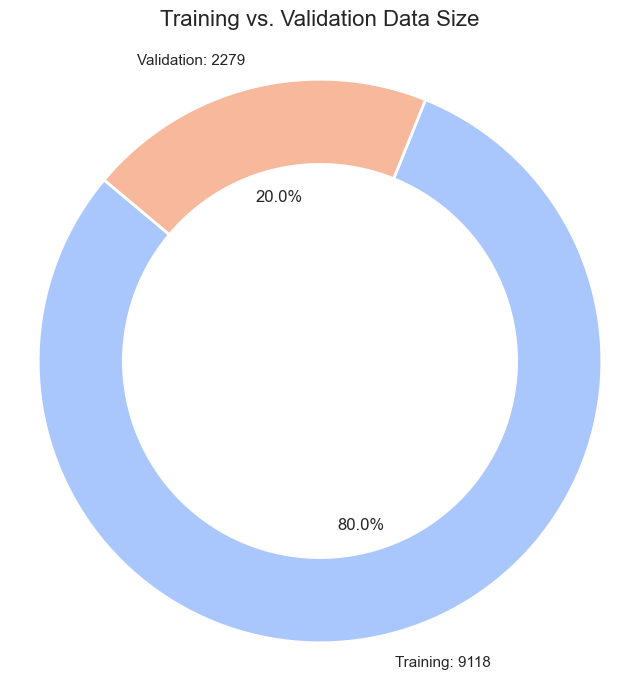

In [6]:
sns.set_theme(style="whitegrid")

# Function to calculate dataset size
def get_dataset_size(dataset):
    return sum([len(batch[0]) for batch in dataset])

train_size = get_dataset_size(train)
validation_size = get_dataset_size(validation)

# Plot pie chart with enhanced aesthetics
sizes = [train_size, validation_size]
labels = ['Training', 'Validation']
sizes_labels = [f'{label}: {size}' for label, size in zip(labels, sizes)]

# Set up color palette for pie chart
colors = sns.color_palette("coolwarm", len(sizes))

plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    labels=sizes_labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Set title with larger font size and padding
plt.title('Training vs. Validation Data Size', fontsize=16, pad=20)

# Add circle in the center to create a donut chart for a modern look
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Equal aspect ratio ensures the pie chart is drawn as a circle
plt.axis('equal')

# Show the plot
plt.show()

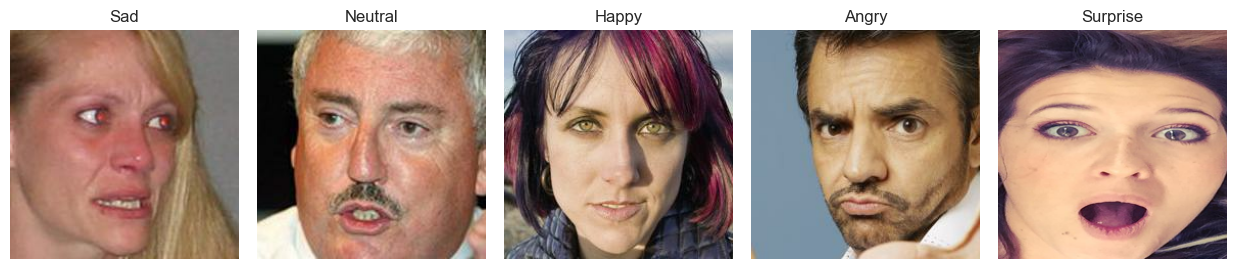

In [7]:
# Get the class names from the training dataset
class_labels = train.class_names

# Set up the figure size for displaying images (adjusted for the number of classes)
plt.figure(figsize=(15, 10))

# Track the classes already shown
shown_classes = set()

# Take one batch from the train dataset
for images, labels in train.take(1):
    for i in range(len(images)):  # Loop through the batch
        class_name = class_labels[labels[i]]
        if class_name not in shown_classes:
            # Plot the image only if its class has not been shown yet
            ax = plt.subplot(1, 6, len(shown_classes) + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")
            shown_classes.add(class_name)
        
        # Stop once all classes have been displayed
        if len(shown_classes) == len(class_labels):
            break

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

In [8]:
# Import the EfficientNetV2M model pre-trained on ImageNet without the top layers
base_model = tf.keras.applications.EfficientNetV2M(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model layers to prevent them from being trained
base_model.trainable = True  #Unfreeze Some Layers for Fine-Tuning

fine_tune_at = len(base_model.layers) - 20  
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Create  model
keras_model = keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.GlobalAveragePooling2D())  # Replace Flatten with GlobalAveragePooling
keras_model.add(keras.layers.BatchNormalization())  # Add a Batch Normalization Layer
keras_model.add(keras.layers.Dense(128, activation='relu'))  # Increase the Model Capacity
keras_model.add(keras.layers.Dropout(0.3))  # Reduce Regularization
keras_model.add(keras.layers.Dense(6, activation=tf.nn.softmax))  # 6 output units for classification

# Display the model's architecture
keras_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 7, 7, 1280)       53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

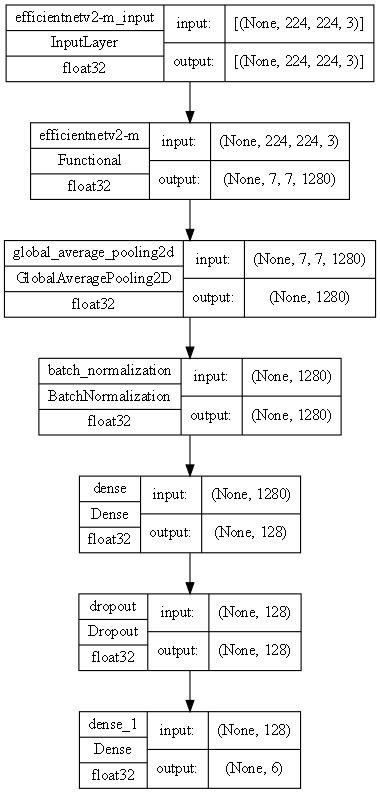

In [9]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [10]:
# Define a checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# Define an early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [11]:
# keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# hist=keras_model.fit_generator(train,epochs=40,validation_data=validation,callbacks=[checkpoint,early_stopping])

In [12]:
keras_model = load_model('EFV2.keras')

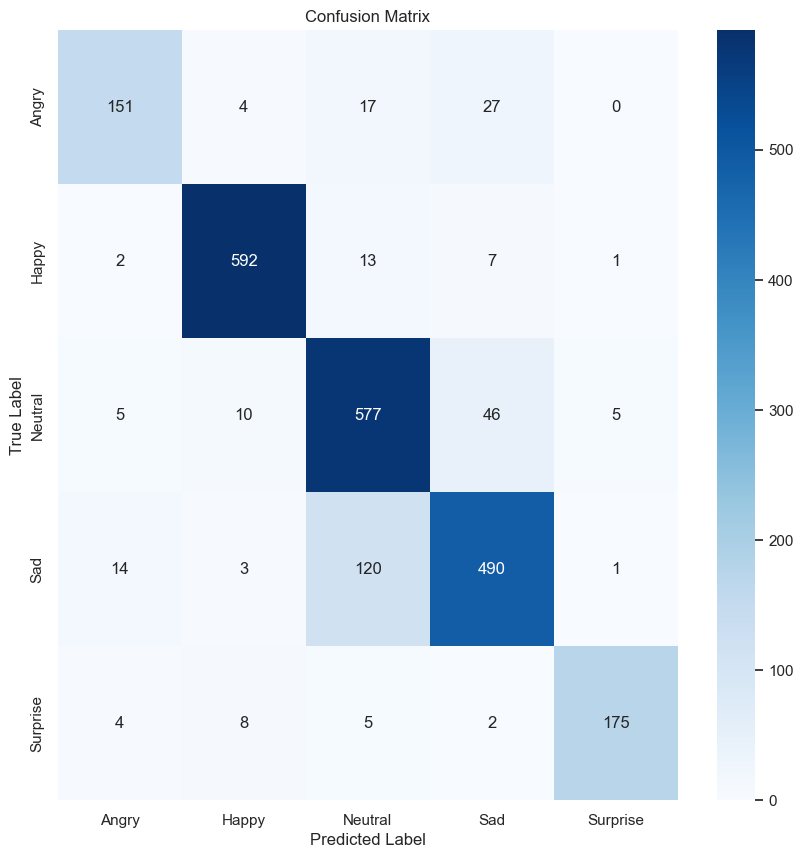

In [13]:
# Function to get true and predicted labels from the dataset
def get_true_and_predicted_labels(model, dataset):
    true_labels = []  # List to store true labels
    predicted_labels = []  # List to store predicted labels
    
    for img_batch, label_batch in dataset:
        predictions = model.predict(img_batch, verbose=0)  # Get model predictions
        predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class labels
        
        # Assume label_batch is already in the correct one-dimensional format
        true_labels.extend(label_batch.numpy())  # Convert true labels to numpy and add to the list
    
    return np.array(true_labels), np.array(predicted_labels)  # Return as numpy arrays

# Get true labels and predicted labels
true_labels, predicted_labels = get_true_and_predicted_labels(keras_model, validation)

# Compute confusion matrix with raw counts
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with raw counts
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',  # 'd' for integer format
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')  # X-axis label
plt.ylabel('True Label')  # Y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()  # Display the plot


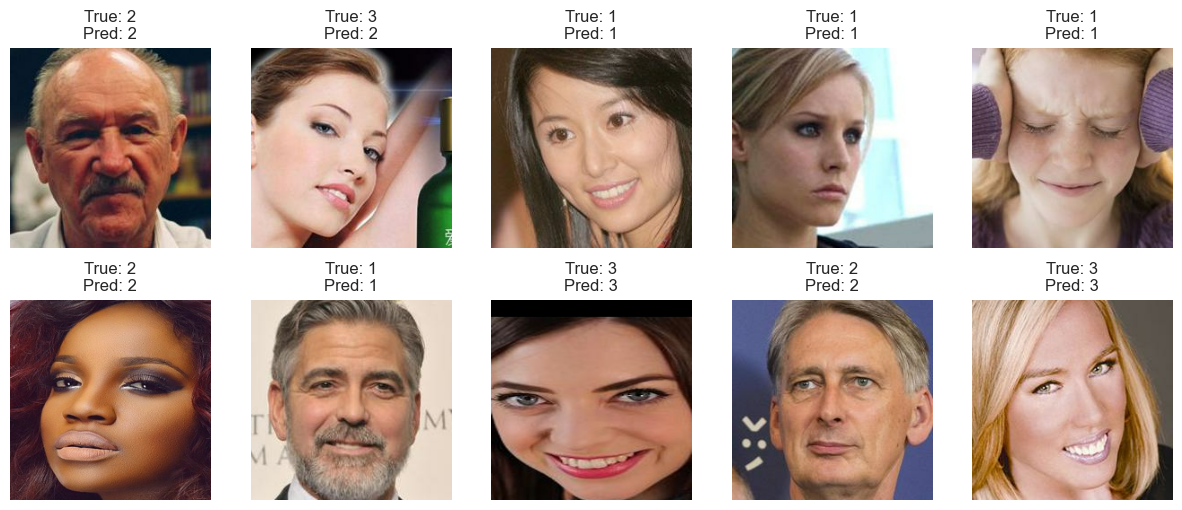

In [14]:
# Function to display images along with their true and predicted labels
def display_images(images, true_labels, predicted_labels, num=10):
    plt.figure(figsize=(15, 6))  # Adjust the figure size to accommodate 10 images
    for i in range(num):
        plt.subplot(2, 5, i + 1)  # Display images in a 2-row, 5-column layout
        plt.imshow(images[i] / 255.0)  # Normalize the image data to the range [0, 1]
        plt.title(f'True: {true_labels[i]}\nPred: {predicted_labels[i]}')  # Show true and predicted labels
        plt.axis('off')  # Hide axis ticks and labels
    plt.show()  # Display the figure

# Get the validation images
val_images = next(iter(validation))[0].numpy()  # Assuming validation is an iterable dataset

# Display the first 10 images along with their true and predicted labels
display_images(val_images, true_labels, predicted_labels, num=10)


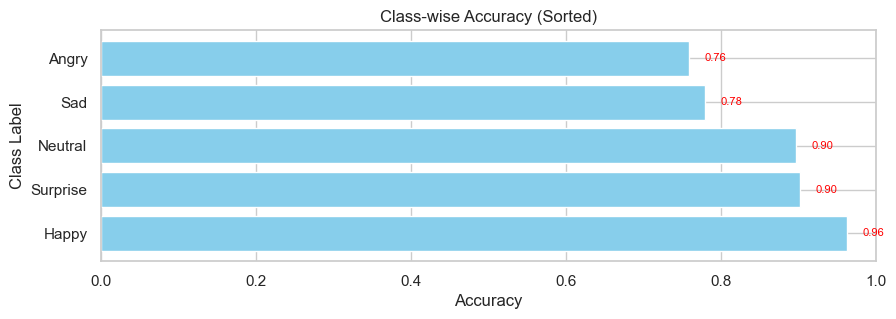

In [15]:
# Calculate accuracy for each class
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Sort class accuracies and corresponding class labels
sorted_indices = np.argsort(class_accuracies)[::-1]  # Indices of accuracies in descending order
sorted_class_labels = np.array(class_labels)[sorted_indices]
sorted_class_accuracies = class_accuracies[sorted_indices]

# Plot class accuracies
plt.figure(figsize=(10, 3))
bars = plt.barh(sorted_class_labels, sorted_class_accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Class Label')
plt.title('Class-wise Accuracy (Sorted)')
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1

# Add the accuracy values outside the bars, vertically centered
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
             va='center', ha='left', fontsize=8, color='red')

plt.show()

In [16]:
score, acc = keras_model.evaluate(validation)
print('validation Loss =', score)
print('validation Accuracy =', acc)

36/36 [==============================] - 66s 2s/step - loss: 0.3607 - accuracy: 0.8710
validation Loss = 0.36068350076675415
validation Accuracy = 0.8709960579872131
